[View in Colaboratory](https://colab.research.google.com/github/SakshiPriya/rnn-names/blob/master/rnnname.ipynb)

In [0]:
import unicodedata
import glob
import io
import re
import string
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as f
import numpy as np

In [0]:
!pip install torch
!pip install torchvision

    100% |████████████████████████████████| 484.0MB 22kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5c7b6000 @  0x7f66a1b431c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
  Using cached https://files.pythonhosted.org/packages/ca/0d/f00b2885711e08bd71242ebe7b96561e6f6d01fdb4b9dcf4d37e2e13c5e1/torchvision-0.2.1-py2.py3-none-any.whl
    100% |████████████████████████████████| 2.0MB 7.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
 !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
 !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
 !apt-get update -qq 2>&1 > /dev/null
 !apt-get -y install -qq google-drive-ocamlfuse fuse
 from google.colab import auth
 auth.authenticate_user()
 from oauth2client.client import GoogleCredentials
 creds = GoogleCredentials.get_application_default()
 import getpass
 !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
 vcode = getpass.getpass()
 !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
lichar=string.ascii_letters+" .,;'"
vocabsize=len(lichar)
chartoint={b:a for a,b in enumerate(lichar)}
filenames=glob.glob('drive/app/data/names/*.txt')
category=[re.search('[ \w-]+?(?=\.)',file).group() for file in filenames]
categorylen=len(category)

def wordcorrection(w):
  k= [ i for i in w if str(i) in lichar]
  return ''.join(k)
      
def readfiles(filename):
    f=io.open(filename,encoding='utf-8')
    word=f.read().strip().split("\n")
    
    # wordli= [unicodedata.normalize('NFKD', w).encode('ascii','ignore') for w in word]
    # print(wordli)
    return [wordcorrection(wd) for wd in word]
  
all_names={}

for file in filenames:
  all_names[re.search('[ \w-]+?(?=\.)',file).group()]=readfiles(file)
  


In [0]:
def onehot(letter):
   print(letter)
   a=torch.zeros(1,vocabsize)
   a[0][chartoint[letter]]=1
   return a
def onehotword(word):
  a=torch.zeros(len(word),1,vocabsize)
  for i in range(len(word)):
    a[i]=onehot(word[i])
  return a
def tcategory(output):
    val,pos=output.topk(1)
    return category[pos],val

def randomcategory():
  k=np.random.randint(0,categorylen)
  
  catname=category[k]
  #print(all_names[catname][np.random.randint(0,len(all_names[catname]))])
  name=all_names[catname][np.random.randint(0,len(all_names[catname]))]
  cattensor = torch.tensor([category.index(catname)], dtype=torch.long)
  nametensor=onehotword(name)
  return catname,name,cattensor,nametensor


  

In [0]:
class basicrnn(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
      super(basicrnn,self).__init__()
      self.hidden_size=hidden_size
      self.input_size=input_size
      self.output_size=output_size
      self.i2h=nn.Linear(self.input_size+self.hidden_size,self.hidden_size)
      self.i2o=nn.Linear(self.input_size+self.hidden_size,self.output_size)
      self.softmax=nn.LogSoftmax(dim=1)
  def forward(self,inputs,hidden):
    combo=torch.cat((inputs,hidden),dim=1)
    
   
    y=self.softmax(self.i2o(combo))
    hidden=self.i2h(combo)
   
    return y,hidden
      
neuron=128

rnn=basicrnn(vocabsize,neuron,categorylen)

In [0]:
lr=0.005

criterion=nn.NLLLoss()
def train(cattensor,nametensor):
   
   hidden=torch.zeros(1,neuron)
   rnn.zero_grad()
   
   for i in range(nametensor.size()[0]):
        output,hidden=rnn(nametensor[i],hidden)
   loss=criterion(output,cattensor)
   loss.backward()
   for param in rnn.parameters():
       param.data+=(-lr*param.grad.data)  
   return output,loss

In [0]:
noofex=100000
currentloss=0
losslist=[]
for i in range(noofex):
  cty,name,cattensor,nametensor=randomcategory()
  outputs,loss=train(cattensor,nametensor)
  currentloss+=loss
  if i%1000:
    print('loss:',currentloss/i)
    print('name:',name)
    print('true category:',cty)
    print('predicted category:',tcategory(outputs))
    print('--------------------------------------------------------------------------------------------------')
    losslist.append(currentloss/i)

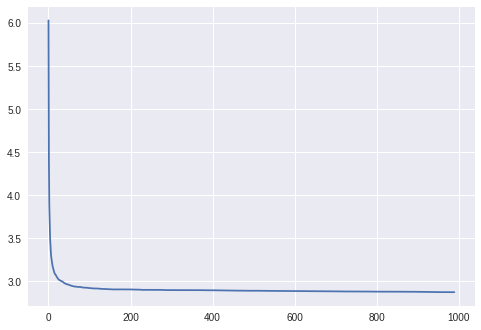

In [64]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(losslist)
plt.show()
